Authors: Daria Buszta, Senbai Kang

Enrich your Xenium data with insights from co-registered IF or H&E staining on the same slide.

# Step 1

Alignment of IF or H&E and Xenium (in this tutorial we will focus on IF, but can be applied to H&E)


1.   With **Xenium Explorer**

*   Following this tutorial: https://www.10xgenomics.com/support/software/xenium-explorer/latest/tutorials/xe-image-alignment

*   You will need the transformation matrix .csv for Step 2

2.   With **warpy** tool in QuPath

*   Find information on the tool here: https://github.com/BIOP/qupath-extension-warpy

*   Once the extension is installed in QuPath, in a project, open both, the IF image and the morphology_focus_0000.ome.tif image from Xenium

*   Both images can be visualised on the same screen by right-clicking and selecting the Multi-view, followed by choosing an appropriate grid size (e.g. Grid 2 x 1 (vertical))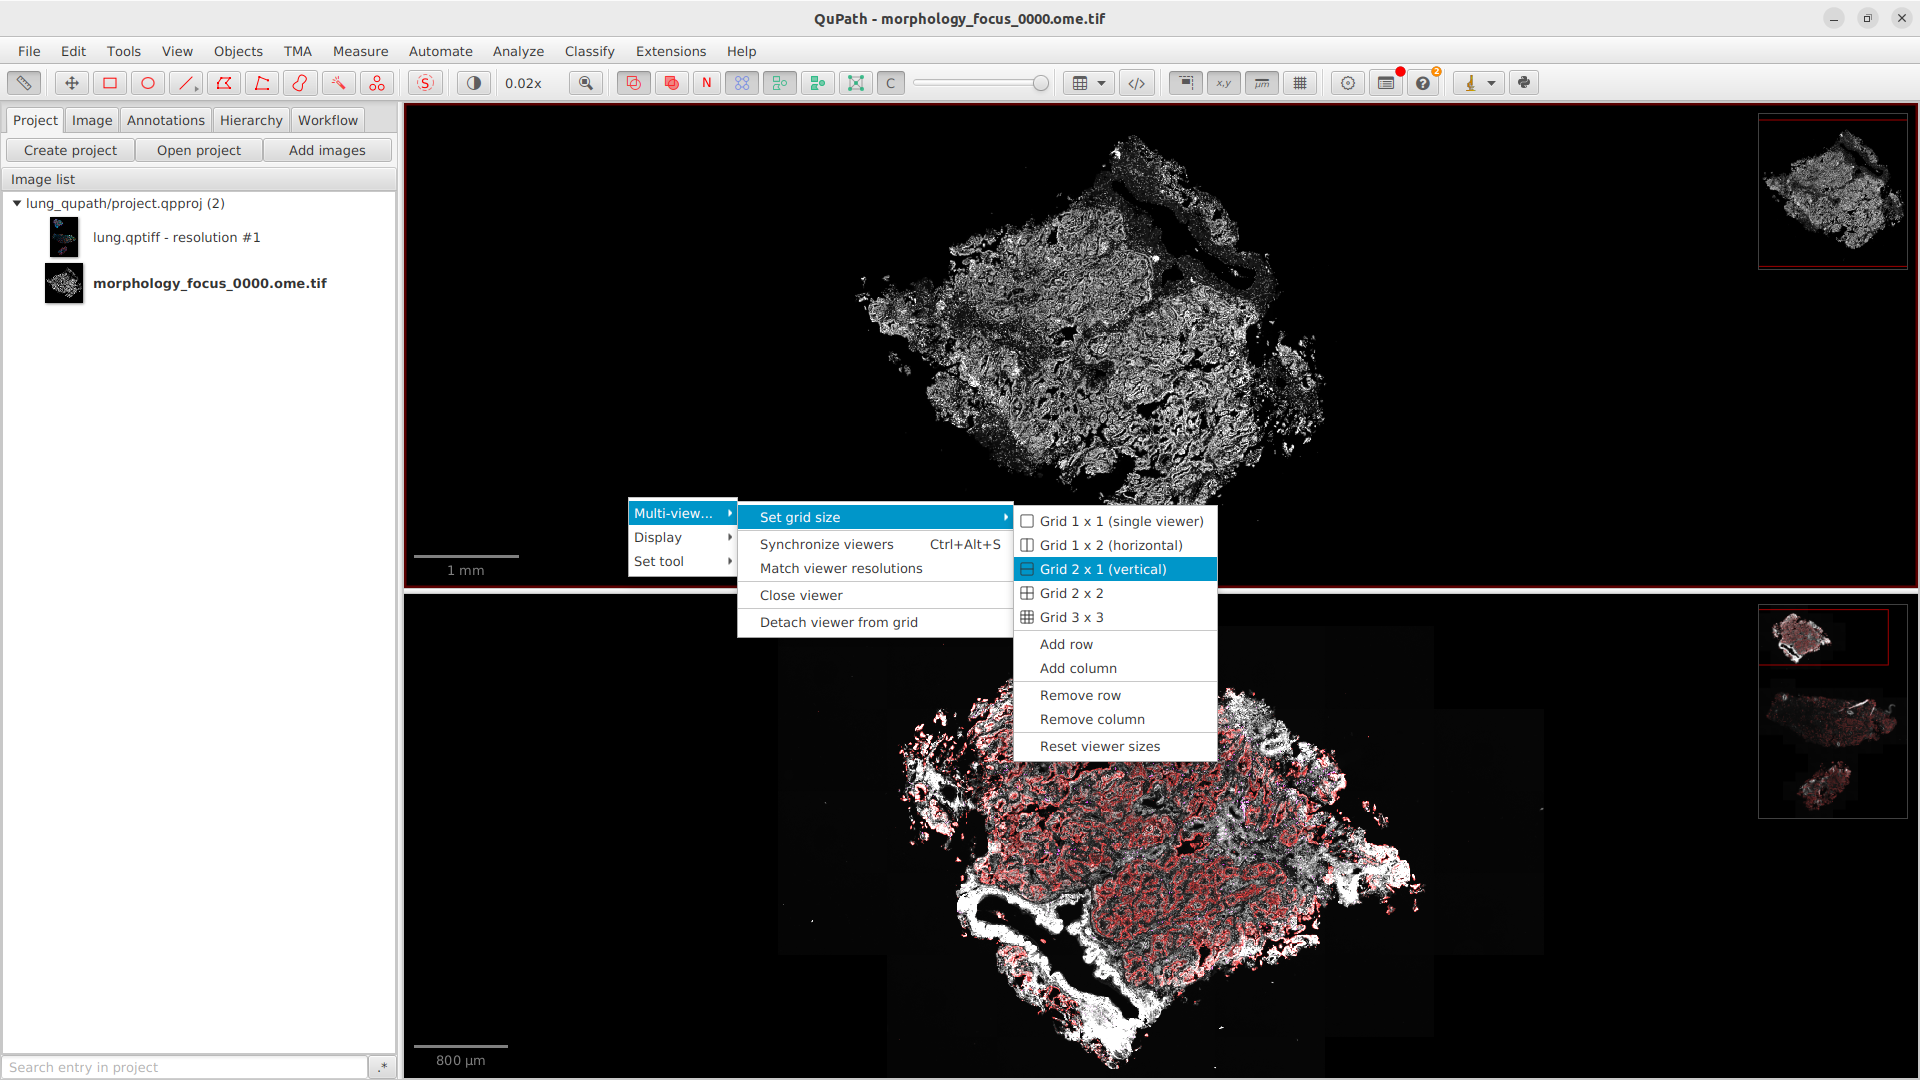

*   Align the IF to the morphology image by going to Analyze > Interactive image combiner Warpy. Here, you can roughly align the images, by rotating and scaling them. Then the final fine-tuning can be done automatically. Reducting the pixel size will result in better alignment but will take longer.
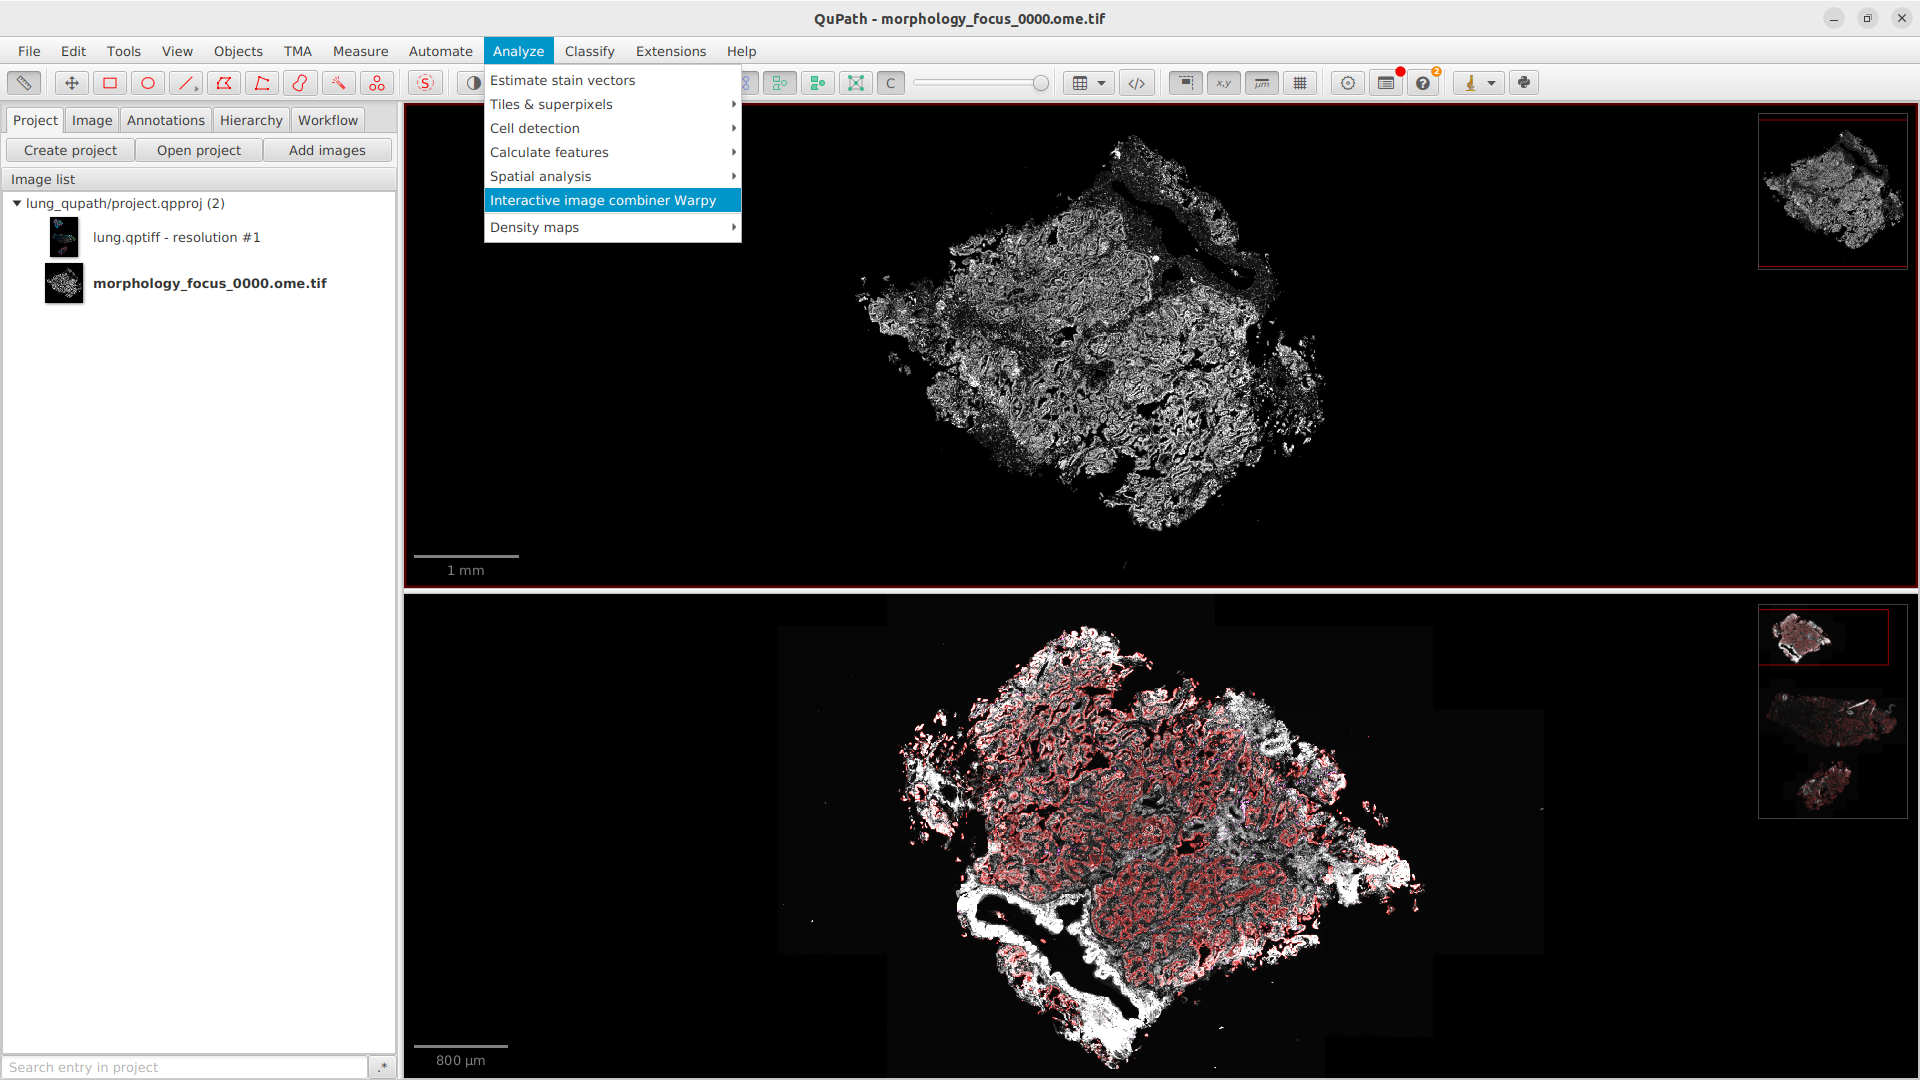

* This will result in an overlay image that can be used in the following steps




# Step 2
Getting cell segmentation as a GeoJSON file with cell ids matching those of Xenium object.

## Import packages

In [ ]:
import os
import json
import uuid
from typing import Callable

import numpy as np
import pandas as pd
import geopandas as gpd

import spatialdata_io as sdio
import spatialdata as sd

import shapely
from shapely.geometry.base import BaseGeometry
from shapely.geometry import mapping, Polygon, MultiPolygon

## Specify several paths

Users should provide the following paths before proceeding.

In [ ]:
# Path to the transform matrix acquired from Step 1, if Xenium Explorer is used for the registration.
transform_mtx_path: str = ""

# Path to the Xenium Ranger output folder.
raw_data_path: str = ""

# Path to the zarr data folder to be saved by SpatialData.
zarr_data_path: str = ""

# Path to the transformed cell polygon file.
geojson_path: str = ""

## Load transform matrix

The transform matrix is only needed if the image registration is done with Xenium Explorer.

In [ ]:
transform_mtx = pd.read_csv(transform_mtx_path, header=None).values

transform_mtx

Since the IF (or the H&E) image is registered against the Xenium image in Step 1, the following equation holds:
\begin{equation}
\begin{pmatrix}
x_1\\
y_1\\
1
\end{pmatrix}
=
M
\begin{pmatrix}
x_2\\
y_2\\
1
\end{pmatrix}
,
\end{equation}
where $[x_1, y_1]^T$ is the coordinates of a point on the Xenium image, $[x_2, y_2]^T$ the coordinates of the corresponding point on the IF (or the H&E) image, and $M$ is the transform matrix. Note that both coordinates are measured in pixels.

Our goal in this tutorial is to map the segmented cells in the Xenium data to the registered IF (or the H&E) image, which requires the inverse of the transform matrix:

In [ ]:
inv_transform_mtx = np.linalg.inv(transform_mtx)

inv_transform_mtx

## Load Xenium data

Load the Xenium data from the provided path to the output folder of Xenium Ranger, and then save to local disk for future use. If it has been loaded and saved before then we will load directly from the local cache.

In [ ]:
if os.path.isdir(zarr_data_path):
    xe_data = sd.read_zarr(zarr_data_path)
else:
    xe_data = sdio.xenium(
        raw_data_path,
        nucleus_boundaries=False,
        cells_as_circles=False,
        cells_labels=False,
    )
    xe_data.write(zarr_data_path)

## Transform the coordinates of cell boundries

The original coordinates of segmented cells in the raw Xenium data are in microns (um). However, the images are registered under pixels (px). Thus, the conversion of unit has to be done before the transformation of coordinates. By default, the pixel size of a full resolution Xenium image is 0.2125um (please refer to [this](https://kb.10xgenomics.com/hc/en-us/articles/11636252598925-What-are-the-Xenium-image-scale-factors) post), and thus the coordinates in um are converted to px by multiplying 1/0.2125.

If the transformed coordinates are to be imported to QuPath as annotations, there is no need to convert the unit, which is now in px, back to um since QuPath requires px as the unit.

In [ ]:
def transform_mtx_by_coords(
    coords: np.ndarray,
    transform_mtx: np.ndarray,
) -> np.ndarray:
    """
    Transform coordinates using a given transform matrix.

    Parameters
    ----------
    coords : np.ndarray
        Array of coordinates to be transformed.
    transform_mtx : np.ndarray
        Transform matrix.

    Returns
    -------
    np.ndarray
        Transformed coordinates.
    """
    return np.matmul(
        transform_mtx,
        np.c_[
            coords,
            np.ones(coords.shape[0]),
        ].transpose(),
    ).transpose()[:, :2]


def process_polygon(
    geom: Polygon,
    transform_mtx: np.ndarray | None = None,
    mat_mul_func: Callable | None = transform_mtx_by_coords,
    scalers: tuple[float, float] = (1 / 0.2125, 1.0),
) -> Polygon:
    """
    Process a polygon geometry by applying a transformation matrix.

    Parameters
    ----------
    geom : Polygon
        Polygon geometry to be processed.
    transform_mtx : np.ndarray | None, optional
        Transform matrix to apply to the coordinates, by default None.
    mat_mul_func : Callable | None, optional
        Function to transform the coordinates, by default
        `transform_mtx_by_coords`.
    scalers : tuple[float, float], optional
        Scalers to transform the coordinates between different units. The first
        scaler converts um to px, while the second converts px to um. By default
        (1 / 0.2125, 1.0).

    Returns
    -------
    Polygon
        Processed polygon geometry.
    """
    coords = np.array(geom.exterior.coords)
    if transform_mtx is None or mat_mul_func is None:
        ret: Polygon = Polygon(
            coords * scalers[0] * scalers[1]
        )  # Keep original geometry
    else:
        ret = Polygon(
            mat_mul_func(
                coords * scalers[0],
                transform_mtx,
            ) * scalers[1]
        )
    return ret


def process_multipolygon(
    geom: MultiPolygon,
    transform_mtx: np.ndarray | None = None,
    mat_mul_func: Callable | None = transform_mtx_by_coords,
    scalers: tuple[float, float] = (1 / 0.2125, 1.0),
) -> MultiPolygon:
    """
    Process a multipolygon geometry by applying a transformation matrix.

    Parameters
    ----------
    geom : MultiPolygon
        Multipolygon geometry to be processed.
    transform_mtx : np.ndarray | None, optional
        Transform matrix to apply to the coordinates, by default None.
    mat_mul_func : Callable | None, optional
        Function to transform the coordinates, by default
        `transform_mtx_by_coords`.
    scalers : tuple[float, float], optional
        Scalers to transform the coordinates between different units. The first
        scaler converts um to px, while the second converts px to um. By default
        (1 / 0.2125, 1.0).

    Returns
    -------
    MultiPolygon
        Processed multipolygon geometry.
    """
    ret: list[Polygon] = []
    for i in geom.geoms:
        ret.append(
            process_polygon(
                i,
                transform_mtx,
                mat_mul_func,
                scalers,
            )
        )

    return MultiPolygon(ret)


def process_raw_boundaries(
    df: gpd.GeoDataFrame,
    *,
    object_type: str = "annotation",
    transform_mtx: np.ndarray | None = None,
    mat_mul_func: Callable | None = transform_mtx_by_coords,
    scalers: tuple[float, float] = (1 / 0.2125, 1.0), # (um2px, px2um)
    first_n: int | None = None,
) -> list:
    """
    Map the coordinates of cell boundries from the raw Xenium data to the
    registered IF (or H&E) image. The transformed coordinates is returned as
    a list of GeoJSON features.

    Note that the coordinates from the raw Xenium data are measured in microns
    (um), while the images are registered under pixels (px). That's why
    additional transformations (specified with `scalers`) are needed for
    different units. Since QuPath takes coordinates of annotations in pixels, we
    do not have to transform the coordinates back to microns.

    Parameters
    ----------
    df : gpd.GeoDataFrame
        GeoDataFrame containing the cell boundries from the raw Xenium data.
    object_type : str, optional
        Object type of the transformed cells to be loaded in QuPath, by default
        "annotation".
    transform_mtx : np.ndarray | None, optional
        Transform matrix, by default None.
    mat_mul_func : Callable | None, optional
        Function to transform the coordinates, by default
        `transform_mtx_by_coords`.
    scalers : tuple[float, float], optional
        Scalers to transform the coordinates between different units. The first
        scaler converts um to px, while the second converts px to um. By default
        (1 / 0.2125, 1.0).
    first_n : int | None, optional
        Number of rows to process for debug purposes, by default None.

    Returns
    -------
    list
        List of GeoJSON features.
    """
    features = []

    idx = 0
    for _, row in df.iterrows():
        if first_n is not None and idx >= first_n:
            break

        geom = row["geometry"]

        if geom.is_empty:
            print("Empty shape found. Skipped.")
            continue

        if geom.geom_type == "Polygon":
            _geom: BaseGeometry = process_polygon(
                geom,
                transform_mtx,
                mat_mul_func,
                scalers,
            )
        elif geom.geom_type == "MultiPolygon":
            _geom = process_multipolygon(
                geom,
                transform_mtx,
                mat_mul_func,
                scalers,
            )
        else:
            raise ValueError(f"Error! Unsupported geometry type: {geom.geom_type}")

        features.append(
            {
                "type": "Feature",
                "id": str(uuid.uuid4()),  # Generate a random uuid
                "geometry": mapping(_geom),
                "properties": {
                    "name": str(
                        row.name
                    ),  # Use the row index or 'cell_id' for feature ID
                    "objectType": object_type,
                },
            }
        )

        idx += 1

    return features

We now transform the coordinates of segmented cells using the functions defined above. Note that the argument, `transform_mtx`, should be ignored if the image registration is done with Warpy.

In [ ]:
cells = process_raw_boundaries(
    xe_data.shapes["cell_boundaries"],
    object_type="detection",
    transform_mtx=inv_transform_mtx,  # comment this line out if Warpy is used to register the images
)

## Save transformed coordinates of cells in GeoJSON

Now the output file is ready to be imported to QuPath.

In [ ]:
with open(
    geojson_path,
    "w",
    encoding="utf-8",
) as fh:
    json.dump(
        {
            "type": "FeatureCollection",
            "features": cells,
        },
        fh,
        separators=(",", ":"),
        indent=4,
    )

# Step 3
In QuPath, you can now do any downstream analysis. For example, classify cells as positive or negative for your fluoresence signal. For more information follow the tutorial here: https://qupath.readthedocs.io/en/stable/docs/tutorials/cell_classification.html